In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Jun 28 08:51:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8     9W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Emergency vs Non-Emergency Vehicle Classification

Fatalities due to traffic delays of emergency vehicles such as ambulance & fire brigade is a huge problem. In daily life, we often see that emergency vehicles face difficulty in passing through traffic. So differentiating a vehicle into an emergency and non emergency category can be an important component in traffic monitoring as well as self drive car systems as reaching on time to their destination is critical for these services.

In this problem, you will be working on classifying vehicle images as either belonging to the emergency vehicle or non-emergency vehicle category. For the same, you are provided with the train and the test dataset. Emergency vehicles usually includes police cars, ambulance and fire brigades.


1. Type of Data and  Problem

Type of data is images.
There are 2 classes in total 


    Emergency Vehicle 
    Non-Emergency Vehicle
    
This is a binary classification problem.    

Problem classificaion where we need to identify the  type of vehicle



In [ ]:
%cd /content/drive/My Drive/analytic Vidhya CV/

/content/drive/My Drive/analytic Vidhya CV


In [ ]:
#imports
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm


from torch.utils.data import Dataset, random_split, DataLoader


# from fastai.vision import *
from PIL import Image,ImageFilter
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline


train_path = 'train.csv'
test_path = 'test.csv'


In [ ]:
#creating a dataset path 
!head "{train_path}"

head: cannot open 'train.csv' for reading: No such file or directory


0 - stands for Non Emergency 
</br>
1 - stands for Emergency

In [ ]:


classes  = [
    'emergency',
    'non_emergency'
    ]




In [ ]:
len(classes)

2

# Image with Label 0

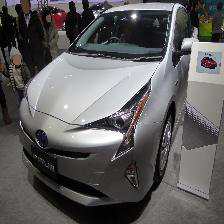

In [ ]:
Image.open('images/1503.jpg')

# Image with Label 1

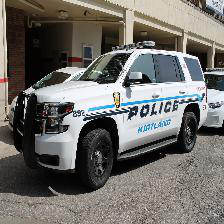

In [ ]:
Image.open('images/45.jpg')


Looking at the images I would like to apply a medium filter.

Lets see the output of the above image without median filter.

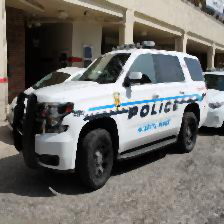

In [ ]:
Image.open('images/45.jpg').filter(ImageFilter.MedianFilter)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


device = get_default_device()


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


# checking class balance 

In [ ]:
train = pd.read_csv('images/train.csv')

print(train.columns)

train['emergency_or_not'].value_counts()

Index(['image_names', 'emergency_or_not'], dtype='object')


0    965
1    681
Name: emergency_or_not, dtype: int64

In [ ]:
class0_index = train[train.emergency_or_not == 0].index.values

class1_index = train[train.emergency_or_not == 1].index.values

In [ ]:
class1_index[0]

5

There is not a huge imbalance we can work with it. Later we can try making both class equal in the data augmentation part.

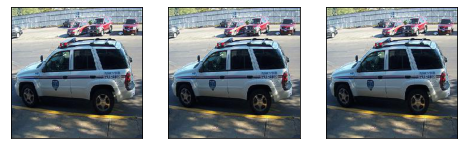

In [ ]:
# Findings 
# There were some images given the wrong class 
# There were some images of the interior (dashboard) of the car instead
# of the cars 

# Since there its a small dataset there are only 706 dataset which can easily 
# be skimmed  through.

#The original EDA Notebook is provided in my github repo.



# Images with wrong labels:

fig,ax = plt.subplots(1,3,figsize = (8,8))

ls = [3,1348,497]

for index,axs in enumerate(ax.flatten()):
 
      axs.imshow(Image.open(f"images/{train.iloc[ls[index]]['image_names']}"))
      axs.set_xticks([])
      axs.set_yticks([])


Instead of changing the the labels I decided to remove the images because there were already present in the train set. So redundent data will only increase the train time. 

removing the above 3 sampels from the train dataframe. I decided to create a new dataframe 

In [ ]:
idx =  [3,1348,497]

#removing rows from train.csv

print(len(train))

train1 = train.drop(axis= 0 ,index = idx)

train1.to_csv('images/train1.csv',index = False)




1646


traning the model on the new dataset imporoved the val_score by 2% 

# Images Not of Cars 


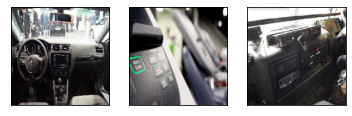

In [ ]:

fig,ax = plt.subplots(1,3)

ls = [240,479,405]

for index,axs in enumerate(ax.flatten()):
 
      axs.imshow(Image.open(f"images/{train.iloc[ls[index]]['image_names']}"))
      axs.set_xticks([])
      axs.set_yticks([])

In [ ]:
idx =  [240,479,405]

#removing rows from train.csv

print(len(train1))

train2 = train1.drop(axis= 0 ,index = idx)

train2.to_csv('images/train2.csv',index = False)

print(len(train2))



1643
1640


# Building The DataSet

In [ ]:
#creating dataset and data loaders

class VehicleDataset(Dataset):
    
    def __init__(self,csv_name,folder,transform = None,label = False):
        
        self.label = label
        
        self.folder = folder
        print(csv_name)
        self.dataframe = pd.read_csv(self.folder+'/'+csv_name+'.csv')
        self.tms = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self,index):
        
        row = self.dataframe.iloc[index]
        
        img_index = row['image_names']
      
        image_file = self.folder + '/' + img_index
    
        image = Image.open(image_file) 
        
        
        if self.label:
            target = row['emergency_or_not']
            
            if target == 0:
              encode  = torch.FloatTensor([1,0])
            else:
              encode = torch.FloatTensor([0,1])

            return self.tms(image),encode
        
        return self.tms(image)


train2
1640
tensor([0., 1.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


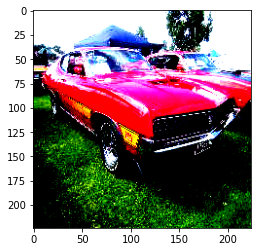

In [ ]:

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

train_dataset =  VehicleDataset('train2','images',label = True,transform=transform)

print(len(train_dataset))
print(train_dataset[20][1])

plt.imshow(train_dataset[1][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


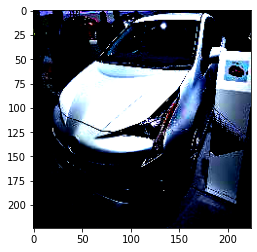

In [ ]:
plt.imshow(train_dataset[0][0].permute(1,2,0))

In [ ]:
test_dataset = VehicleDataset('test','images',transform=transform)

print(len(test_dataset))
test_dataset[0].shape

test
706


torch.Size([3, 224, 224])

In [ ]:
train_dataset

In [ ]:
torch.manual_seed(101)


batch_size = 32

val_pct = 0.2

val_size = int(val_pct * len(train_dataset))
train_size = len(train_dataset) - val_size

print(train_size,val_size)

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)



1312 328


(1312, 328)

# dataloaders

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)


In [ ]:
for i,y in train_dl:

  print(i.shape,y.shape)

  break

torch.Size([32, 3, 224, 224]) torch.Size([32, 2])


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f6aec141240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [ ]:
def show_batch(batch_size = 32,dl = None ):
    
    
    for image,label in dl:
        
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        
        ax.imshow(make_grid(image.cpu(), nrow=5).permute(1, 2, 0))
        
        break
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


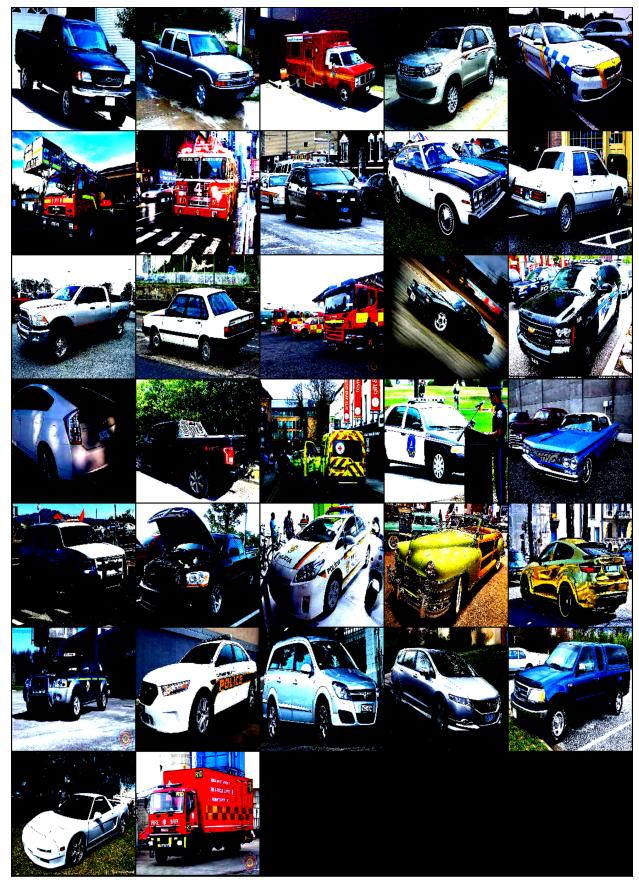

In [ ]:
show_batch(dl = train_dl)

In [ ]:
import gc 
gc.collect()

754

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    _,truths = torch.max(labels,dim = 1)
    return torch.tensor(torch.sum(preds == truths).item() / len(preds))



In [ ]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)     
        # _,out = torch.max(out,dim = 1)                 
        loss = F.binary_cross_entropy(torch.sigmoid(out), targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)      

                                                # Generate predictions
        loss = F.binary_cross_entropy(torch.sigmoid(out), targets) 
       
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(),'val_score':score.detach()}
        
    #this 2 methods will not change .
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [ ]:
class EmergencyCustomModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            # nn.Sigmoid(),
        )
  def forward(self, xb):
        return self.network(xb)

In [ ]:
device

device(type='cuda')

In [ ]:
custom_model = to_device(EmergencyCustomModel(),device)


In [ ]:
custom_model

EmergencyCustomModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
# custom_model.forward(torch.rand((1,3,200,200))).dtype

torch.float32

In [ ]:

torch.cuda.empty_cache()

Training and Validation Methods 

In [ ]:
# defining the training method.

#using weight decay and cyclic lr , gradient clipping

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
    #                                             steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # # # Record & update learning rate
            # lrs.append(get_lr(optimizer))
            # sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def fit(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
   
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
          
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
evaluate(custom_model,val_dl)

{'val_loss': 0.6917869448661804, 'val_score': 0.5785984992980957}

Using simple fit function.
Experimenting with weight decay and gradient clipping 

Keeping everything constant and verying only one parameter eg. weight decay or gradient clipping.
We can observe who the parameter will effect the learnig 


In [ ]:
# using 
wd = [10,1,1e-1,1e-2,1e-3,1e-4]
epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

hist = {}

for weight_decay in wd:

  print(weight_decay)
  custom_model = to_device(EmergencyCustomModel(),device)
  torch.cuda.empty_cache()
  hist[weight_decay] = fit(epochs,lr,custom_model,train_dl,val_dl,weight_decay,
                  opt_func = opt_func)


10
Epoch [0], train_loss: 0.6916, val_loss: 0.6923, val_score: 0.5786
Epoch [1], train_loss: 0.6924, val_loss: 0.6927, val_score: 0.5786
Epoch [2], train_loss: 0.6928, val_loss: 0.6928, val_score: 0.5786
Epoch [3], train_loss: 0.6928, val_loss: 0.6929, val_score: 0.5786
Epoch [4], train_loss: 0.6928, val_loss: 0.6928, val_score: 0.5786
Epoch [5], train_loss: 0.6928, val_loss: 0.6928, val_score: 0.5786
Epoch [6], train_loss: 0.6928, val_loss: 0.6928, val_score: 0.5786
Epoch [7], train_loss: 0.6928, val_loss: 0.6928, val_score: 0.5786
Epoch [8], train_loss: 0.6928, val_loss: 0.6929, val_score: 0.5786
Epoch [9], train_loss: 0.6928, val_loss: 0.6928, val_score: 0.5786
1
Epoch [0], train_loss: 0.6850, val_loss: 0.6889, val_score: 0.5786
Epoch [1], train_loss: 0.6882, val_loss: 0.6896, val_score: 0.5786
Epoch [2], train_loss: 0.6897, val_loss: 0.6902, val_score: 0.5786
Epoch [3], train_loss: 0.6901, val_loss: 0.6904, val_score: 0.5786
Epoch [4], train_loss: 0.6900, val_loss: 0.6904, val_scor

In [ ]:
def get_df(hist,ls):
    data = {}

    for i in ls:
        train_loss = 0
        val_loss = 0
        val_score = 0
        for j in range(epochs):

            train_loss += hist[i][j]['train_loss']
            val_loss += hist[i][j]['val_loss']
            val_score += hist[i][j]['val_score']

        train_loss /= epochs
        val_loss /= epochs
        val_score /= epochs

        data[i] = [train_loss,val_loss,val_score]

    return pd.DataFrame(data,index = ['train_loss','val_loss','val_score']).T


In [ ]:
get_df(hist,wd)

,train_loss,val_loss,val_score
10.0000,0.692641,0.692760,0.578598
1.0000,0.689356,0.690101,0.578598
0.1000,0.580963,0.711388,0.647790
0.0100,0.367633,2.083718,0.656944
0.0010,0.315336,0.977198,0.725347
0.0001,0.312453,0.762554,0.745234


Experimenting with Gradient Clipping.
Weight decay  = 1e-3

In [ ]:
best_wd = 1e-3
gradient_clipping = [1,0.3,0.2,0.1,0.001,0]
epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

hist2 = {}

for clipping in gradient_clipping:

  print(clipping)
  custom_model = to_device(EmergencyCustomModel(),device)
  torch.cuda.empty_cache()
  hist2[clipping] = fit(epochs,lr,custom_model,train_dl,val_dl,best_wd,
                  clipping,opt_func = opt_func)


1
Epoch [0], train_loss: 0.5164, val_loss: 0.5566, val_score: 0.7383
Epoch [1], train_loss: 0.4007, val_loss: 0.4092, val_score: 0.8166
Epoch [2], train_loss: 0.3394, val_loss: 1.9359, val_score: 0.5054
Epoch [3], train_loss: 0.2901, val_loss: 0.3937, val_score: 0.8280
Epoch [4], train_loss: 0.2789, val_loss: 0.6640, val_score: 0.7156
Epoch [5], train_loss: 0.2953, val_loss: 0.3126, val_score: 0.8706
Epoch [6], train_loss: 0.2229, val_loss: 0.4358, val_score: 0.8592
Epoch [7], train_loss: 0.2455, val_loss: 1.2713, val_score: 0.6199
Epoch [8], train_loss: 0.2043, val_loss: 0.7129, val_score: 0.7740
Epoch [9], train_loss: 0.2185, val_loss: 0.3366, val_score: 0.8535
0.3
Epoch [0], train_loss: 0.5135, val_loss: 1.6352, val_score: 0.7156
Epoch [1], train_loss: 0.4008, val_loss: 1.1953, val_score: 0.6443
Epoch [2], train_loss: 0.3862, val_loss: 0.4174, val_score: 0.8134
Epoch [3], train_loss: 0.3035, val_loss: 0.3977, val_score: 0.8138
Epoch [4], train_loss: 0.2916, val_loss: 0.9519, val_sco

In [ ]:
get_df(hist2,gradient_clipping)

,train_loss,val_loss,val_score
1.000,0.301196,0.702870,0.758112
0.300,0.303732,0.631757,0.787121
0.200,0.330270,1.294376,0.638510
0.100,0.331202,1.290196,0.680429
0.001,0.339965,0.848173,0.750158
0.000,0.306174,1.420101,0.674495


# With Weight decay 1e-4

In [ ]:
best_wd = 1e-4
gradient_clipping = [1,0.3,0.2,0.1,0.001,0]
epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

hist2 = {}

for clipping in gradient_clipping:

  print(clipping)
  custom_model = to_device(EmergencyCustomModel(),device)
  torch.cuda.empty_cache()
  hist2[clipping] = fit(epochs,lr,custom_model,train_dl,val_dl,best_wd,
                  clipping,opt_func = opt_func)


1
Epoch [0], train_loss: 0.5596, val_loss: 0.5178, val_score: 0.7610
Epoch [1], train_loss: 0.4101, val_loss: 0.6802, val_score: 0.6547
Epoch [2], train_loss: 0.3612, val_loss: 0.4981, val_score: 0.8166
Epoch [3], train_loss: 0.3755, val_loss: 0.7539, val_score: 0.6998
Epoch [4], train_loss: 0.3316, val_loss: 0.5207, val_score: 0.7923
Epoch [5], train_loss: 0.2777, val_loss: 0.3333, val_score: 0.8564
Epoch [6], train_loss: 0.2546, val_loss: 0.4235, val_score: 0.8166
Epoch [7], train_loss: 0.2825, val_loss: 0.5531, val_score: 0.7854
Epoch [8], train_loss: 0.2497, val_loss: 0.3503, val_score: 0.8535
Epoch [9], train_loss: 0.1868, val_loss: 1.1214, val_score: 0.6515
0.3
Epoch [0], train_loss: 0.5538, val_loss: 0.6095, val_score: 0.6897
Epoch [1], train_loss: 0.3875, val_loss: 0.6292, val_score: 0.6973
Epoch [2], train_loss: 0.3254, val_loss: 1.5268, val_score: 0.6143
Epoch [3], train_loss: 0.3026, val_loss: 0.5763, val_score: 0.7598
Epoch [4], train_loss: 0.2605, val_loss: 0.3956, val_sco

In [ ]:
get_df(hist2,gradient_clipping)

,train_loss,val_loss,val_score
1.000,0.328936,0.575221,0.768782
0.300,0.283878,0.854528,0.713321
0.200,0.312944,1.413985,0.715404
0.100,0.294405,0.528740,0.779956
0.001,0.314526,0.805157,0.754703
0.000,0.304526,0.599188,0.770360


For weight decay 1e-3 the heighest val score is 78 and for weight deacy 1e-4 the height score is 77 

but its can be seen that the model overfits more when weight decay is 1e-3 then 1e-4. 

So going for weight decay 1e-4 and no gradient clipping 

In [ ]:
# final Learning with 
lr  = 1e-3
epochs = 20

best_wd = 1e-4
gradient_clipping = 0


custom_model = to_device(EmergencyCustomModel(),device)
torch.cuda.empty_cache()
hist = fit(epochs,lr,custom_model,train_dl,val_dl,best_wd,
                gradient_clipping,opt_func = opt_func)


Epoch [0], train_loss: 0.5263, val_loss: 0.6611, val_score: 0.7159
Epoch [1], train_loss: 0.3967, val_loss: 0.4400, val_score: 0.7955
Epoch [2], train_loss: 0.3564, val_loss: 0.3701, val_score: 0.8551
Epoch [3], train_loss: 0.3142, val_loss: 0.3122, val_score: 0.8807
Epoch [4], train_loss: 0.2823, val_loss: 0.4225, val_score: 0.8125
Epoch [5], train_loss: 0.2640, val_loss: 0.4597, val_score: 0.7955
Epoch [6], train_loss: 0.2409, val_loss: 1.3221, val_score: 0.5710
Epoch [7], train_loss: 0.2585, val_loss: 0.6893, val_score: 0.6932
Epoch [8], train_loss: 0.2041, val_loss: 0.5651, val_score: 0.8324
Epoch [9], train_loss: 0.1755, val_loss: 0.5370, val_score: 0.8267
Epoch [10], train_loss: 0.1714, val_loss: 0.3790, val_score: 0.8551
Epoch [11], train_loss: 0.1622, val_loss: 0.5643, val_score: 0.8324
Epoch [12], train_loss: 0.1282, val_loss: 0.9425, val_score: 0.7017
Epoch [13], train_loss: 0.2085, val_loss: 0.4710, val_score: 0.8409
Epoch [14], train_loss: 0.1185, val_loss: 0.3998, val_scor

In [ ]:
len(hist)

20

In [ ]:
def plot(hist,epochs = 10):
  train_loss = []
  val_loss = []
  val_score = []
  for i in range(epochs):

      train_loss.append(hist[i]['train_loss'])
      val_loss.append(hist[i]['val_loss'])
      val_score.append(hist[i]['val_score'])

  plt.plot(train_loss,label = 'train_loss')
  plt.plot(val_loss,label = 'val_loss')
  plt.legend()
  plt.title('loss')

  plt.figure()
  plt.plot(val_score,label = 'val_score')
  plt.legend()
  plt.title('accuarcy')


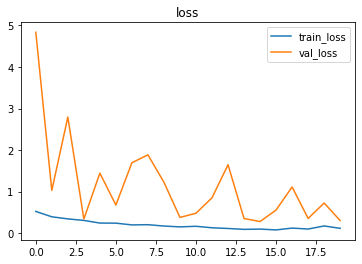

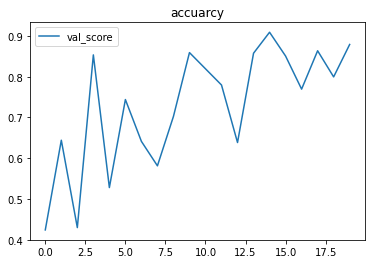

In [ ]:
plot(hist)

To reduce the overfitting by  using dropout

In [ ]:
models.resnet50(pretrained=True).fc.in

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
class ResNet50(ImageClassificationBase):

    def __init__(self):
      super().__init__()
      self.pretrained_model = models.resnet50(pretrained = True)
      
      feature_in = self.pretrained_model.fc.in_features
      self.pretrained_model.fc = nn.Linear(feature_in,2)

    def forward(self,x):
      return self.pretrained_model(x)

In [ ]:
# final Learning with 
lr  = 1e-4
epochs = 5
opt_func = torch.optim.Adam
best_wd = 1e-4
gradient_clipping = 0


custom_model = to_device(ResNet50(),device)
torch.cuda.empty_cache()
hist = fit(epochs,lr,custom_model,train_dl,val_dl,best_wd,
                gradient_clipping,opt_func = opt_func)


Epoch [0], train_loss: 0.2342, val_loss: 0.1272, val_score: 0.9517
Epoch [1], train_loss: 0.0360, val_loss: 0.1143, val_score: 0.9659
Epoch [2], train_loss: 0.0118, val_loss: 0.1166, val_score: 0.9659
Epoch [3], train_loss: 0.0089, val_loss: 0.1247, val_score: 0.9659
Epoch [4], train_loss: 0.0036, val_loss: 0.1066, val_score: 0.9688


Wow!! Using the same model i keras (resnet 50) I could get highest accuracy of 94 % here is 96% and sometimes 97%

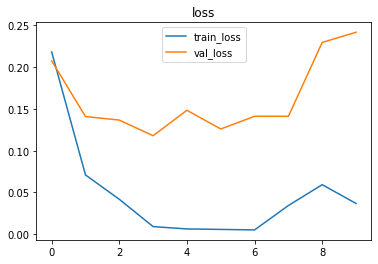

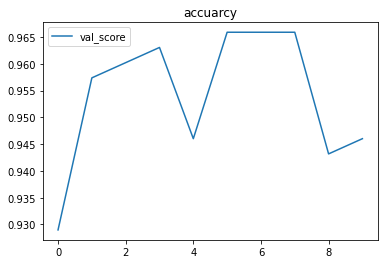

In [ ]:
plot(hist)

In [ ]:
torch.save(custom_model.cpu(),'models/resnet50.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResNet50. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:

custom_model = to_device(ResNet50(),device)
torch.cuda.empty_cache()
hist = fit_one_cycle(5, 1e-4, custom_model, train_dl, val_dl, 
                  weight_decay=1e-4, grad_clip=0, opt_func=torch.optim.Adam)

Epoch [0], train_loss: 0.2328, val_loss: 0.1410, val_score: 0.9545
Epoch [1], train_loss: 0.0858, val_loss: 0.1694, val_score: 0.9517
Epoch [2], train_loss: 0.0682, val_loss: 0.1224, val_score: 0.9631
Epoch [3], train_loss: 0.0471, val_loss: 0.1256, val_score: 0.9574
Epoch [4], train_loss: 0.0423, val_loss: 0.1692, val_score: 0.9432


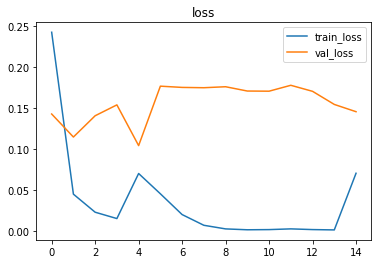

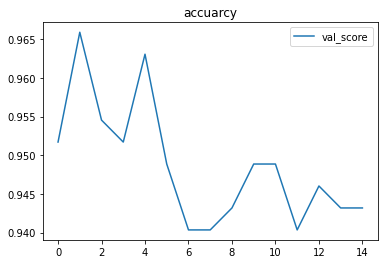

In [ ]:
plot(hist,15)

Densenet 

In [ ]:
class Densenet169(ImageClassificationBase):

    def __init__(self):
      super().__init__()
      self.pretrained_model = models.densenet169(pretrained = True)
      
      feature_in = self.pretrained_model.classifier.in_features
      self.pretrained_model.classifier = nn.Linear(feature_in,2)

    def forward(self,x):
      return self.pretrained_model(x)

In [ ]:
# final Learning with 
lr  = 1e-4
epochs = 5
opt_func = torch.optim.Adam
best_wd = 1e-4
gradient_clipping = 0


custom_model2 = to_device(Densenet169(),device)
torch.cuda.empty_cache()
hist = fit(epochs,lr,custom_model2,train_dl,val_dl,best_wd,
                gradient_clipping,opt_func = opt_func)


Epoch [0], train_loss: 0.2712, val_loss: 0.1358, val_score: 0.9545
Epoch [1], train_loss: 0.0668, val_loss: 0.1003, val_score: 0.9602
Epoch [2], train_loss: 0.0208, val_loss: 0.1181, val_score: 0.9631
Epoch [3], train_loss: 0.0117, val_loss: 0.1449, val_score: 0.9602
Epoch [4], train_loss: 0.0064, val_loss: 0.1586, val_score: 0.9517


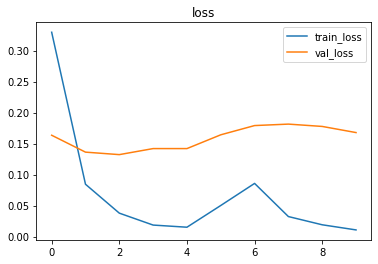

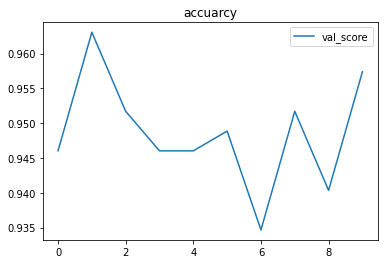

In [ ]:
plot(hist)

# Saving the Model

In [ ]:
# torch.save(custom_model2.cpu(),'models/densenet.pth')

torch.save(custom_model2.state_dict(),'models/densenet169_final.pt')

#Loading Model

In [ ]:
loaded_densenet169 = Densenet169()
loaded_densenet169.load_state_dict(torch.load('models/densenet169_1.pt'))
loaded_densenet169.eval()
print('loaded')

loaded


Preparation Submission File

In [ ]:

preds = []
for test_image in test_dataset:
    test_image = test_image.view(1,3,224,224)
    pred  = loaded_densenet169.forward(test_image)
    _,idx = torch.max(pred,dim = 1)
    idx = idx.numpy()[0]
    preds.append(idx)

In [ ]:
pd.Series(preds).value_counts()

0    400
1    306
dtype: int64

In [ ]:
subs = pd.read_csv('sample_submission.csv')
subs.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,0
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


In [ ]:
subs['emergency_or_not'] = preds
subs.to_csv('densenet169_epochs5.csv',index = False)

In [ ]:

preds = []
for image,labels in train_dataset:
 

    image = image.view(1,3,224,224)
    
    pred  = loaded_densenet169.forward(img)
    _,idx = torch.max(pred,dim = 1)
    idx = idx.numpy()[0]
    preds.append(idx)
    print(idx)
    break
    
    
    
